In [1]:
import cv2
import kagglehub
from ultralytics import YOLO
import os
import yaml
from sklearn.cluster import DBSCAN
from PIL import Image, ImageTk

d:\dev\2025\pokervision\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# download playing card dataset using kagglehub
data_path = kagglehub.dataset_download("andy8744/playing-cards-object-detection-dataset")
print(data_path)
os.listdir(data_path)

C:\Users\Mark\.cache\kagglehub\datasets\andy8744\playing-cards-object-detection-dataset\versions\4


['data.yaml',
 'kaggle_data.yaml',
 'README.roboflow.txt',
 'test',
 'train',
 'valid']

In [4]:
# get dataset labels
with open(data_path + "/data.yaml", "r") as file:
	data = yaml.safe_load(file)

labels = data["names"]
print(labels)

['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']


In [5]:
# create model using previously trained weights
model = YOLO("CardDetector.pt")

In [6]:
# class for storing card information, could make cards persistent between
# frames later
class CardPrediction:
	def __init__(self, position, left, right, top, bottom, class_id, suit_rank, confidence):
		self.position = position
		self.left = left
		self.right = right
		self.top = top
		self.bottom = bottom
		self.class_id = class_id
		self.suit_rank = suit_rank
		self.confidence = confidence
		self.hand = -1

	def draw(self, frame):
		cv2.rectangle(frame, 
				 	  (self.left, self.top),
					  (self.right, self.bottom), 
					  (0, 255, 0), 
					  1)
		cv2.circle(frame,
				   self.position,
				   3,
				   (0, 255, 0),
				   -1)
		cv2.putText(frame, 
					f"{self.suit_rank}({self.hand}): {self.confidence:.2f}", 
					(self.left, self.top - 30), 
					cv2.FONT_HERSHEY_SIMPLEX, 
					0.5, 
					(0, 255, 0), 
					1, 
					cv2.LINE_AA)

In [2]:
# analyse in real-time 

cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_AUTOFOCUS, 255)
#cam.set(cv2.CAP_PROP_FOCUS, 100)
cam.set(cv2.CAP_PROP_BRIGHTNESS, 100)

while True:
	# get new frame
	_, frame = cam.read() 

	# TODO: does the model expect rgb or bgr???

	# detect cards
	cards = []
	prediction = next(model.track(frame, stream=True, verbose=False, persist=True))
	if prediction.boxes.id != None:
		for i, box_id in enumerate(prediction.boxes.id):
			# get attributes of identified card
			x1, y1, x2, y2 = prediction.boxes.xyxy[i]
			x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
			cx, cy, _, _ = prediction.boxes.xywh[i]
			cx, cy = int(cx), int(cy)
			class_id = int(prediction.boxes.cls[i])
			conf = prediction.boxes.conf[i]

			# create new prediction object and add to list
			cards.append(CardPrediction((cx, cy), x1, x2, y1, y2, class_id, labels[class_id], conf))

		# using DBSCAN clustering algo to group card hands
		positions = []
		for card in cards:
			positions.append(card.position)
		hand_labels = DBSCAN(eps=100, min_samples=2).fit(positions).labels_
		for i, label in enumerate(hand_labels):
			cards[i].hand = label

		# draw the card annotations
		for card in cards:
			card.draw(frame)

		# draw hand clustering
		for i, card1 in enumerate(cards):
			if i == len(cards) - 1:
				break
			for card2 in cards[i+1:]:
				if card1.hand != -1 and card1.hand == card2.hand:
					cv2.line(frame, 
			  				 card1.position, 
							 card2.position, 
							 (0, 255, 0), 
							 2)

	# show the image
	cv2.imshow("pokervision", frame)

	# close the window on any keypress
	if cv2.waitKey(1) != -1:
		break

cam.release()
cv2.destroyAllWindows()	

NameError: name 'model' is not defined

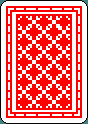

In [4]:
Image.open("../res/SBS - 2D Poker Pack/Top-Down/Cards/Card_Back-88x124.png").crop((0, 0, 88, 124))

In [13]:
myList = [1, 2, 3, 4, 5, 6]
to_delete = []
for i, val in enumerate(myList):
	print(val)
	if val == 3 or val == 5:
		to_delete.append(i)

to_delete.reverse()
for i in to_delete:
	del myList[i]

print(myList)

1
2
3
4
5
6
[1, 2, 4, 6]
